# Quality Prediction - Classification

In [1]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import xgboost as xgb
import numpy as np

In [2]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201878
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_reduced_new")
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_reduced_new",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/201878/fs/201797/fv/wine_reduced_new/version/1


In [5]:
X = feature_view.get_batch_data()
X

Finished: Reading data from Hopsworks, using ArrowFlight (1.30s) 


,key,type,volatile_acidity,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,6123,1,0.46,0.091,18.0,77.0,0.99922,3.15,0.51,9.4
1,2172,0,0.32,0.042,11.0,117.0,0.99600,3.23,0.37,9.2
2,5331,1,0.39,0.091,6.0,18.0,1.00040,3.16,0.49,9.5
3,3135,0,0.39,0.057,51.0,221.0,0.99851,3.26,0.51,8.9
4,5129,1,0.38,0.078,12.0,49.0,0.99625,3.37,0.52,9.9
...,...,...,...,...,...,...,...,...,...,...
6492,1947,0,0.45,0.051,61.0,197.0,0.99320,3.02,0.40,9.0
6493,2671,0,0.30,0.030,38.0,142.0,0.98892,3.41,0.41,12.9
6494,4395,0,0.24,0.051,35.0,146.0,0.99676,3.10,0.67,9.4
6495,1942,0,0.36,0.052,35.0,256.0,1.00010,2.93,0.64,8.6


Given that the relationships between features and the target variable are complex and nonlinear, we use Extreme Gradient Boosting as a model, in order to capture intricate patterns and interactions in the data.

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.77s) 


In [7]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [8]:
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
metrics

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8},
 '4': {'precision': 0.2,
  'recall': 0.16666666666666666,
  'f1-score': 0.1818181818181818,
  'support': 42},
 '5': {'precision': 0.5737327188940092,
  'recall': 0.5737327188940092,
  'f1-score': 0.5737327188940092,
  'support': 434},
 '6': {'precision': 0.5794223826714802,
  'recall': 0.5846994535519126,
  'f1-score': 0.5820489573889392,
  'support': 549},
 '7': {'precision': 0.5307017543859649,
  'recall': 0.5238095238095238,
  'f1-score': 0.5272331154684097,
  'support': 231},
 '8': {'precision': 0.29545454545454547,
  'recall': 0.37142857142857144,
  'f1-score': 0.32911392405063294,
  'support': 35},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 'accuracy': 0.546923076923077,
 'macro avg': {'precision': 0.3113302002008571,
  'recall': 0.3171909906215262,
  'f1-score': 0.3134209853743104,
  'support': 1300},
 'weighted avg': {'precision': 0.5449506941851612,
  'recall': 0.5469230769230

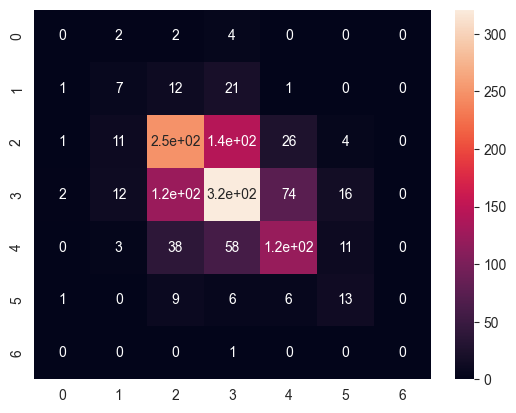

In [9]:
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

We can employ different classification approaches to highlight their differences and how fitting they are for the dataset. First, a logistic regression model can provide initial explorative analysis and see if the dataset presents notable linearity. More complex predictors can be leveraged to further extract information from the data.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [15]:
print(best_params)

{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

classifier = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_leaf=1, min_samples_split=5, random_state=50, class_weight = 'balanced')

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.60      0.21      0.32        42
           5       0.74      0.73      0.73       434
           6       0.65      0.76      0.70       549
           7       0.67      0.58      0.62       231
           8       0.75      0.34      0.47        35
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.49      0.37      0.41      1300
weighted avg       0.68      0.68      0.67      1300



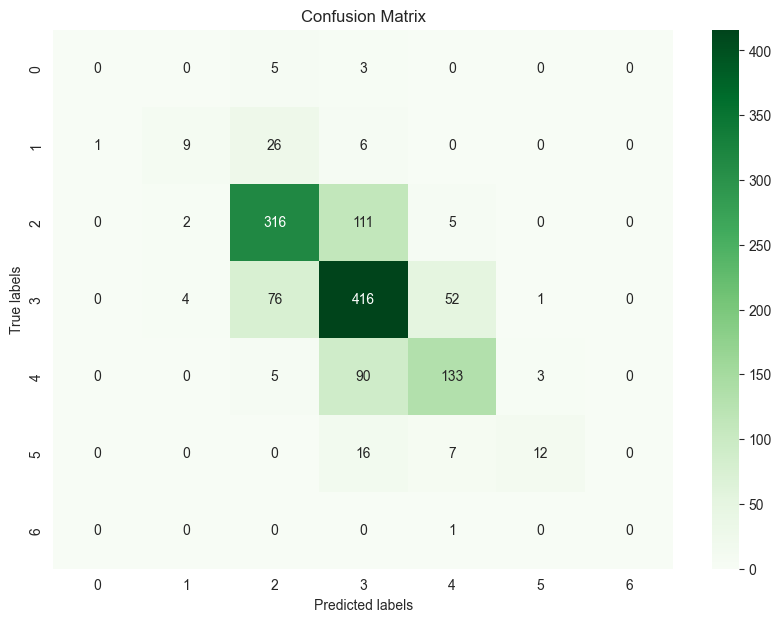


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



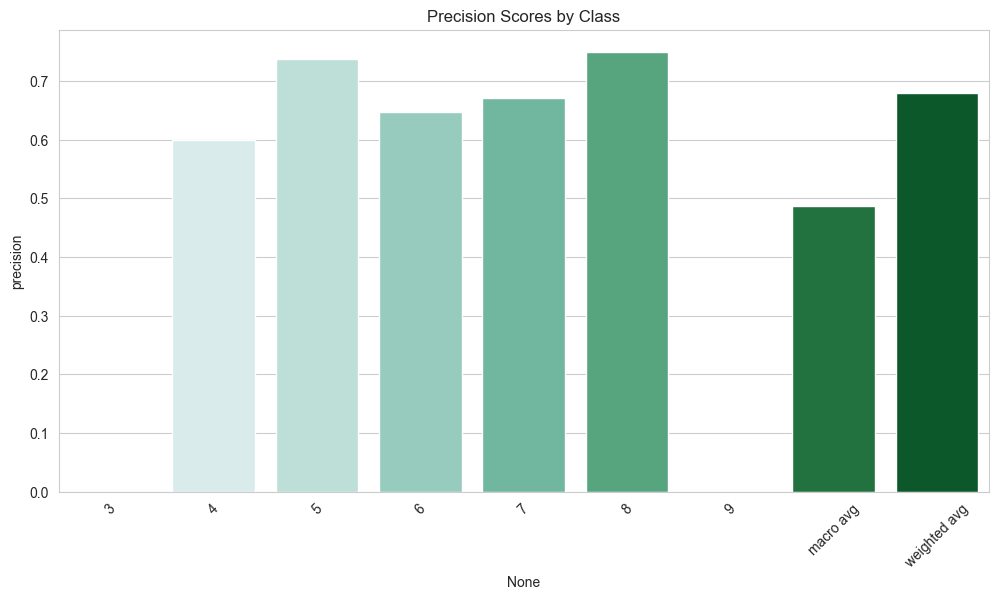

In [17]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report Visualization
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy'], inplace=True)  # Drop the total accuracy row
report_df['support'] = report_df['support'].apply(int)  # Convert support to int

# Plotting Precision, Recall, and F1-Score
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df, x=report_df.index, y='precision', palette='BuGn')
plt.title('Precision Scores by Class')
plt.xticks(rotation=45)
plt.show()

In [18]:
! pip install imblearn

You should consider upgrading via the 'c:\users\utente\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


We can train and visualize the outcomes of a logistic regression approach. As we can notice, the accuracy score is relatively low, only being slightly better than a random classifier. This is mostly due to the low support of classes 3,4,8,9, which the model is unable to predict efficiently.

In [19]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model_class"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(classifier, model_dir + "/wine_model_class.pkl")
fig.savefig(model_dir + "/confusion_matrix_class.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model_class",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/201878/models/wine_model_class/1


Model(name: 'wine_model_class', version: 1)